In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import abc
from tqdm import tqdm

## The language of modules
Most model architectures in modern deep learning can be thought of as a
composition of _modules_.

**Definition.** A _module_ refers to a function $X \times W \to Y,$
where $X$ denotes the space of inputs, $W$ denotes the space of learnable
weights, and $Y$ is the space of outputs.

**Example.** The activation function ReLU is a module
$X = \mathbb{R} \to [0, \infty)$ with no learnable weights, as is Softmax $X = \mathbb{R}^c \to [0, 1],$
where $c$ denotes the number of classes.

**Example.** The loss function MSE is a
module $X = \mathbb{R} \times \mathbb{R} \to [0, \infty)$ with no learnable weights, as is
CrossEntropy $X = \mathbb{R}^c \times \{{\bf e}_1, \dotsc, {\bf e}_c\} \to \mathbb{R}.$

**Example.** A linear module $\text{Linear}(a, b)$ with $a$ in-features and
$b$ out-features is a module
$X \times W = \mathbb{R}^a \times (\mathbb{R}^{b \times a} \times \mathbb{R}^b) \to \mathbb{R}^b$
defined as $({\bf x}, ({\bf W}, {\bf b})) \mapsto {\bf W}{\bf x} + {\bf b}.$
It has precisely $(a + 1)b$ learnable weights.

Composing modules produces new modules, accummulating the learnable weights and
passing unused ones into the next layers. More precisely, given modules
$X \times V \xrightarrow{f} Y$ and $Y \times W \xrightarrow{g} Z,$ their
composition $g \circ f$ is defined by
$$X \times (V \times W) \xrightarrow{f \times 1} Y \times W \xrightarrow{g} Z \xrightarrow{L} \mathbb{R}.$$

**Key Example.** A neural network is a certain sequence of these modules, such
as the following one with 1 hidden layer of size $h$ that can perform
classification on data in $\mathbb{R}^n$ for $c$ classes:
$$\text{Softmax} \circ \text{Linear}(h, c) \circ \text{ReLU} \circ \text{Linear}(n, h).$$
There are exactly $(n + 1)h + (h + 1)c$ learnable weights in this module,
coming from the two linear layers.

## Training a module

**Strategy.** Let $X \times U \to Y$ be a module, which we will think of as complicated,
e.g. a deep neural network. We will learn the weights by choosing a loss
function $Y \xrightarrow{L} \mathbb{R}$ and minimizing
$X \times U \to Y \xrightarrow{L} \mathbb{R}$
by performing gradient descent on the weights $U.$ To compute the gradient with
respect to $u,$ we divide and conquer by expressing the complicated module as a
composition $g \circ f$ of simpler modules $X \times V \xrightarrow{f} Y$ and
$Y \times W \xrightarrow{g} Z$ where $U = V \times W$ and using chain rule:
$$(\nabla_w Lgf)(x, v, w) = (\nabla_w Lg)(f(x, v), w),$$
$$(\nabla_v Lgf)(x, v, w) = (\nabla_y Lg)(f(x, v), w) \cdot (\nabla_v f)(x, v).$$
The latter gradient is the nontrivial one to compute, and we call this
`grad_weights`.

**Details.**
In the above expression for `grad_weights` we have two things that cannot be
computed locally in the recursion:
- the term $f(x, v)$ which we call `output`,
- the crucial $(\nabla_y Lg)(f(x, v), w)$ term which we call `grad_output`.

To obtain `output`, we simply feed $(x, v, w)$ through the module before
starting the recursion and store the outputs at each submodule. To obtain
`grad_output`, we bravely assume it comes with the recursion, so we must compute
and pass on the gradient
$$(\nabla_x Lgf)(x, v, w) = (\nabla_y Lg)(f(x, v), w) \cdot (\nabla_x f)(x, v)$$
of the input.

## Implementation

Here is some elementary code to generate toy data and train and test a model.

In [2]:
def one_hot_encode(y, n_classes):
    return np.identity(n_classes)[y.astype(int)]

def generate_data(dataset_name, n_samples=100):
    match dataset_name:
        case 'regression: an affine line':
            X = np.random.uniform(-5, 5, size=(n_samples, 1))
            y = 3 * X - 100
        case 'regression: cubic polynomial':
            X = np.random.uniform(-5, 5, size=(n_samples, 1))
            y = X ** 3 - 2 * X + 5
        case 'classification: linearly separable':
            X = np.random.normal(size=(n_samples, 2))
            y = one_hot_encode((X[:, 0] > X[:, 1] + 1).astype(int), 2)
        case 'classification: XOR':
            X = np.random.normal(size=(n_samples, 2))
            y = one_hot_encode((X[:, 0] * X[:, 1] > 0).astype(int), 2)
        case _:
            raise ValueError('invalid dataset name')
    return X, y


def train_and_test(
        model, loss_fn, optimizer, dataset_name,
        n_epochs=5000, n_samples=100
):
    # train
    X_train, y_train = generate_data(dataset_name, n_samples=n_samples)
    losses = []
    for _ in tqdm(range(n_epochs)):
        output = model.forward(X_train)
        loss = loss_fn.forward(output, y_train) 
        losses.append(loss)
        model.backward(loss_fn.backward())
        optimizer.step()
        
    # test and plot
    X_test, y_test = generate_data(dataset_name, n_samples=n_samples)
    fig, ax = plt.subplots(ncols=2)
    fig.set_size_inches(10, 5)
    ax[0].set_title('loss during training')
    ax[1].set_title('predictions and truth')
    if dataset_name.startswith('classification'):
        y_pred = np.argmax(model.forward(X_test), axis=1)
        sns.lineplot(losses, ax=ax[0])
        sns.scatterplot(
            x=X_test[:, 0], y=X_test[:, 1],
            hue=np.argmax(y_test, axis=1), ax=ax[1]
        )
        sns.scatterplot(
            x=X_test[:, 0], y=X_test[:, 1],
            hue=y_pred, s=100, alpha=0.2, ax=ax[1]
        )
        plt.legend([],[], frameon=False)
    elif dataset_name.startswith('regression'):
        y_pred = model.forward(X_test)
        sns.lineplot(losses, ax=ax[0])
        sns.scatterplot(x=X_test[:, 0], y=y_test[:, 0], ax=ax[1])
        sns.scatterplot(
            x=X_test[:, 0], y=y_pred[:, 0],
            s=100, alpha=0.2, ax=ax[1]
        )
        plt.legend([],[], frameon=False)

Here are the general `Module`, `Composition`, and `SGD` classes.

In [3]:
class Module:
    # require inheriting classes to implement the abstract methods
    __metaclass__ = abc.ABCMeta 

    def __init__(self, name):
        '''
        Stores learnable weights in a dictionary `self.weights` keyed by
        strings.
        '''
        self.name = name
        self.weights = {}
        self.grad_weights = {}

    @abc.abstractmethod
    def forward(self, input):
        '''
        Computes the output of the module, then stores the output in
        `self.output` and returns it.
        '''
        pass

    @abc.abstractmethod
    def backward(self, grad_output):
        '''
        Computes `self.grad_weights` organized as a dictionary in the same
        way as `self.weights` and returns `grad_input`.
        '''
        pass

    def __repr__(self):
        return self.name


class Composition(Module): # in PyTorch this is called `Sequential`

    def __init__(self, submodules):
        self.submodules = submodules
        self.name = f'Composition({", ".join(s.name for s in submodules)})'
        self.weights = {
            f'{submodule.name}.{weight_name}': weight
            for submodule in self.submodules
            for weight_name, weight in submodule.weights.items()
        }

    def forward(self, input):
        '''Feed the input forward.'''
        for submodule in self.submodules:
            input = submodule.forward(input)
        return input
    
    def backward(self, grad_output):
        '''Propogate the gradients backward.'''
        for submodule in reversed(self.submodules):
            grad_output = submodule.backward(grad_output)
        self.grad_weights = {
            f'{submodule.name}.{weight_name}': grad_weight
            for submodule in self.submodules
            for weight_name, grad_weight in submodule.grad_weights.items()
        }
        return grad_output
    

class SGD:

    def __init__(self, module, lr=1e-3):
        self.module = module
        self.lr = lr

    def step(self):
        for weight_name, weight in self.module.weights.items():
            weight -= self.lr * self.module.grad_weights[weight_name]
   

Here is MSE which has the straightforward gradient
$$(\nabla_{\bf y} \text{MSE})({\bf y}, {\bf t}) = {2 \over b} ({\bf y} - {\bf t}).$$

In [4]:
class MSE(Module):

    def __init__(self):
        super().__init__('MSE')

    def forward(self, input_y, input_t):
        self.input_y, self.input_t = input_y, input_t
        return np.mean((input_y - input_t) ** 2)
    
    def backward(self):
        return 2 * (self.input_y - self.input_t) / len(self.input_t)

For a linear layer, the gradients with respect to the weights are
$$(\nabla_{\bf W} \text{Linear})({\bf x}, ({\bf W}, {\bf b})) = {\bf x} \hspace{0.5cm}\text{and}\hspace{0.5cm} (\nabla_{\bf b} \text{Linear})({\bf x}, ({\bf W}, {\bf b})) = {\bf 1},$$
and the gradient with respect to the input is
$$(\nabla_{\bf x} \text{Linear})({\bf x}, ({\bf W}, {\bf b})) = {\bf W}.$$

In [5]:
class Linear(Module):

    def __init__(self, n_in_features, n_out_features):
        super().__init__(f'Linear({n_in_features}, {n_out_features})')
        self.n_in_features = n_in_features
        self.n_out_features = n_out_features
        
        # Don't worry about this choice of weight initializations; for examples
        # of other choices, see https://pytorch.org/docs/stable/nn.init.html
        stdv = 1.0 / np.sqrt(self.n_in_features)
        sample_unit_ball = lambda size: np.random.uniform(-stdv, stdv, size)
        self.weights = {
            'W': sample_unit_ball((n_out_features, self.n_in_features)),
            'b': sample_unit_ball((n_out_features, ))
        }

    def forward(self, input):
        self.input = input
        return input @ self.weights['W'].T + self.weights['b']

    def backward(self, grad_output):
        self.grad_weights = {
            'W': grad_output.T @ self.input,
            'b': grad_output.T @ np.ones((len(self.input), ))
        }
        grad_linear = self.weights['W']
        return grad_output @ grad_linear

**Test.** Check that you can learn an affine line. This requires `Composition`,
`Linear`, `MSE`, and `SGD` to work.

100%|██████████| 100/100 [00:00<00:00, 32721.98it/s]


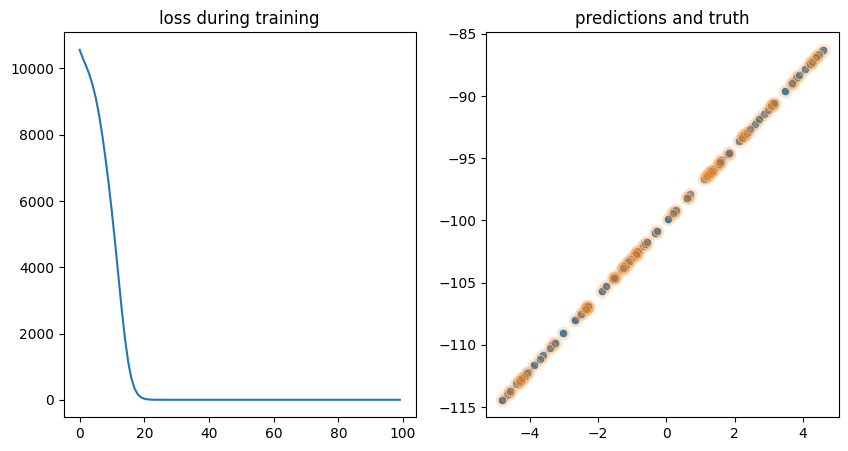

In [6]:
model = Composition([
    Linear(1, 8),
    Linear(8, 1)
])

train_and_test(
    model=model,
    loss_fn=MSE(),
    optimizer=SGD(model, lr=1e-3),
    dataset_name='regression: an affine line',
    n_epochs=100,
    n_samples=100
)

Here are the usual activation functions implemented as `Module`s. The gradient
for `ReLU` is easy, and the gradient for `Softmax` is
$$(\nabla \text{Softmax})({\bf a}) = \text{diag}({\bf a}) - {\bf a}{\bf a}^T.$$

In [7]:
class Softmax(Module):

    def __init__(self, n_classes):
        super().__init__(f'Softmax({n_classes})')
        self.n_classes = n_classes

    def forward(self, input):
        input = input - np.max(input)
        p = np.exp(input)
        sums = np.sum(p, axis=1)
        self.output = (p.T / sums.T).T
        return self.output
    
    def backward(self, grad_output):
        # hacks :)
        s = self.output
        diag = np.einsum('ij, jk -> ijk', s, np.identity(s.shape[1]))
        outer = np.einsum('ij, ik -> ijk', s, s)
        grad_softmax = diag - outer
        return np.einsum('ijk, ik -> ij', grad_softmax, grad_output)


class ReLU(Module):

    def __init__(self):
        super().__init__('ReLU')

    def forward(self, input):
        self.input = input
        return input * (input > 0)
    
    def backward(self, grad_output):
        grad_relu = (self.input > 0)
        return grad_output * grad_relu

**Test.** Check that you can learn a cubic polynomial. This requires `ReLU`
to work. You should play with the hyperparameter `H`, e.g. try the values
`H = 4` and `H = 32`.

100%|██████████| 5000/5000 [00:00<00:00, 15297.77it/s]


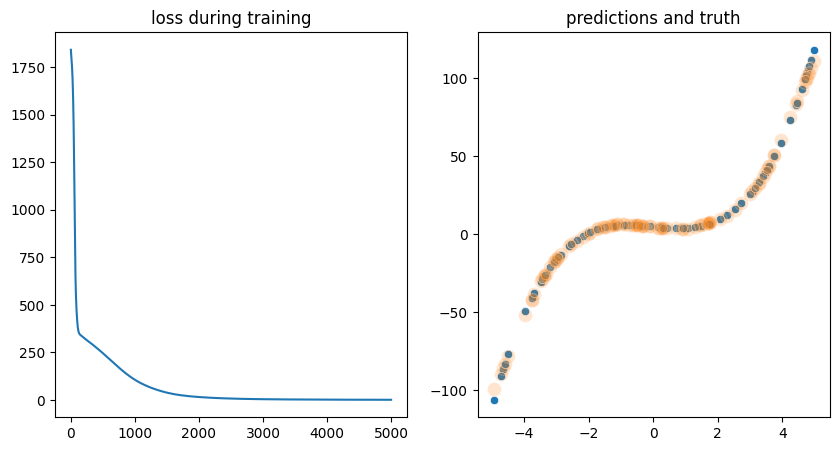

In [8]:
H = 32

model = Composition([
    Linear(1, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, 1),
])

train_and_test(
    model,
    MSE(),
    SGD(model, lr=1e-4),
    'regression: cubic polynomial',
    n_epochs=5000,
    n_samples=100
)

Having implemented the finnicky Softmax module and recalled the gradient of MSE,
we've arrived at the following extremely important point:

**Important clarification.** Recall the nice identity showing that the gradient
of CrossEntropy is, up to a scalar, the gradient of MSE:
$$\nabla_{\bf y} (\text{CrossEntropy} \circ \text{Softmax})({\bf y}, {\bf t}) = {1 \over b}(\text{Softmax}({\bf y}) - {\bf t}).$$
Many sources, including the textbook and the previous sentence, are vague (or
often just wrong) when they say this. The things to remember are the following:
- the gradient is of the composition of Softmax followed by CrossEntropy
- the gradient is being taken with respect to the input to the Softmax
- the term in the RHS involving the input is the Softmax of the input.

**Remark.** There is even confusion about this in practice. Since Softmax is almost
always directly followed by CrossEntropy, these are typically implemented as
one module; in fact, one of my pet peeves about PyTorch is that their
`nn.CrossEntropyLoss` includes the Softmax! Moreover, since accidentally taking
Softmax twice (e.g. applying Softmax before calling PyTorch's
`nn.CrossEntropyLoss`) causes moderate but not horrifyingly-bad problems,
often such mistakes go unresolved.

Inspired by this nice identity that we have (only) for the gradient of the
composition, we will implement Softmax and CrossEntropy as one module; this 
indeed throws away the hard work we did for the backward method of Softmax.

In [9]:
class SoftmaxCrossEntropy(Module):

    def __init__(self, n_classes):
        super().__init__(f'CrossEntropy({n_classes})')
        self.n_classes = n_classes
        self.softmax = Softmax(n_classes)

    def forward(self, input, t):
        self.t = t
        # at least the forward method of `Softmax` will not be wasted
        self.softmax_output = self.softmax.forward(input) 
        # the 1e-6 is for numerical stability
        return -np.mean(t * np.log(self.softmax_output + 1e-6)) 
    
    def backward(self):
        return (self.softmax_output - self.t) / len(self.t) # goated identity

**Test.** Check that you can classify linearly separable data. This requires
`SoftmaxCrossEntropy` to work but no activation functions.

100%|██████████| 1000/1000 [00:00<00:00, 18138.55it/s]


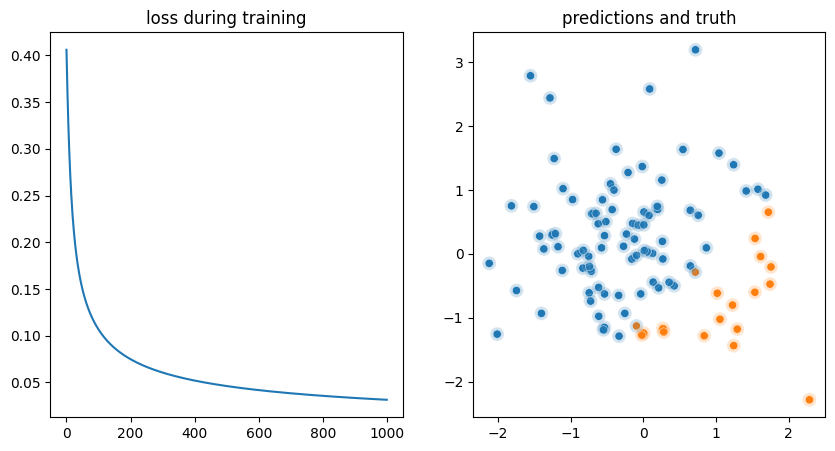

In [10]:
H = 32

model = Composition([
    Linear(2, H),
    Linear(H, 2),
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: linearly separable',
    n_epochs=1000,
    n_samples=100
)

**Test.** Check that you can learn XOR. This requires everything to work, and you'll need to adjust the hyperparameters `H` and `n_epochs`.

100%|██████████| 5000/5000 [00:00<00:00, 7751.86it/s]


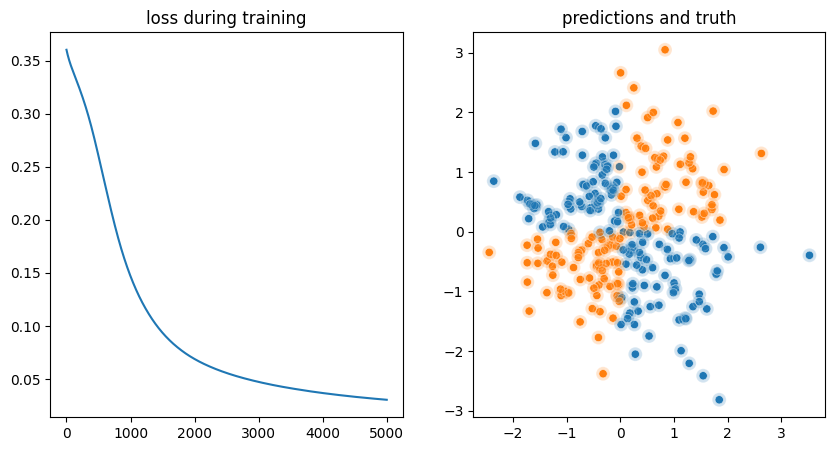

In [11]:
H = 32

model = Composition([
    Linear(2, H),
    ReLU(),
    Linear(H, H),
    ReLU(),
    Linear(H, 2)
])

train_and_test(
    model,
    SoftmaxCrossEntropy(2),
    SGD(model, lr=1e-2),
    'classification: XOR',
    n_epochs=5000,
    n_samples=250
)